# An example on convolutional neural networks
Here I have followed the following [example](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) for a convolution neural network.

## Import.STONKS()

And also check whether the GPU is available

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.autograd import Variable

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


## Downloading data

Downloading a big library of data!

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)


### How does our training set look?

We plot an example from our dataset

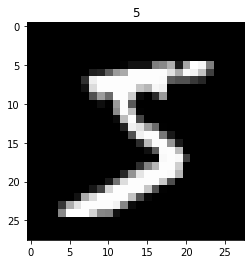

In [3]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()


We can also plot multiple images from our training set... wauv

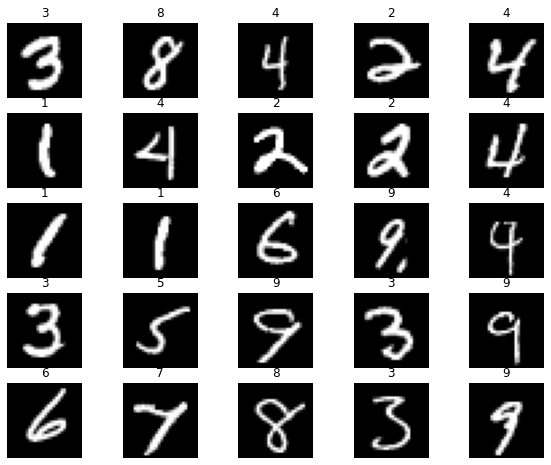

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Preparing data for training

Our training data needs to prepped for the network, this is easily accomplished with the dataloaders.

In [5]:
loaders = {
    'train' : torch.utils.data.DataLoader(
        train_data, 
        batch_size=100, 
        shuffle=True, 
        num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(
        test_data, 
        batch_size=100, 
        shuffle=True, 
        num_workers=1),
}

## Define the convolutional neural network

The model obviously also needs to be defined:

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size = 2),    
        )
          
        self.conv2 = nn.Sequential(            
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),  
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size = 2),                
        )
        
        # fully connected layer, output 10 classes
        ## TODO: 4 * 4 was changed from 7 * 7, as a test
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()

## Defining loss and optimization function

Both the loss function and the optimization function needs to be defined for this particular neural network.
They are defined as follows.

(Why it is always that CrossEntropyLoss.. I do not know)

In [7]:
lrn_rt = 1e-3
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = lrn_rt)

## Training the network

In [8]:
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        
        pass
    
    
    pass
train(num_epochs, cnn, loaders)
print("Done!")

Epoch [1/10], Step [100/600], Loss: 0.2740
Epoch [1/10], Step [200/600], Loss: 0.1229
Epoch [1/10], Step [300/600], Loss: 0.1435
Epoch [1/10], Step [400/600], Loss: 0.1598
Epoch [1/10], Step [500/600], Loss: 0.0661
Epoch [1/10], Step [600/600], Loss: 0.0251
Epoch [2/10], Step [100/600], Loss: 0.0718
Epoch [2/10], Step [200/600], Loss: 0.0668
Epoch [2/10], Step [300/600], Loss: 0.0814
Epoch [2/10], Step [400/600], Loss: 0.0987
Epoch [2/10], Step [500/600], Loss: 0.0901
Epoch [2/10], Step [600/600], Loss: 0.0232
Epoch [3/10], Step [100/600], Loss: 0.0238
Epoch [3/10], Step [200/600], Loss: 0.0453
Epoch [3/10], Step [300/600], Loss: 0.0532
Epoch [3/10], Step [400/600], Loss: 0.0048
Epoch [3/10], Step [500/600], Loss: 0.0350
Epoch [3/10], Step [600/600], Loss: 0.0786
Epoch [4/10], Step [100/600], Loss: 0.0121
Epoch [4/10], Step [200/600], Loss: 0.0501
Epoch [4/10], Step [300/600], Loss: 0.0120
Epoch [4/10], Step [400/600], Loss: 0.0081
Epoch [4/10], Step [500/600], Loss: 0.0283
Epoch [4/10

## Evaluating model

Next we would like to evaluate our network with the available test data



In [9]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.99


## Test on random images
Finally we would like to see the model evaluate on some random images of the test data.

In [10]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
print(f"The dimensions of the images: {imgs.shape}")

The dimensions of the images: torch.Size([100, 1, 28, 28])


Prediction number:		 [7 9 5 1 8 6 5 4 3 1]
Actual number:		 [7 9 5 1 8 6 5 4 3 1]


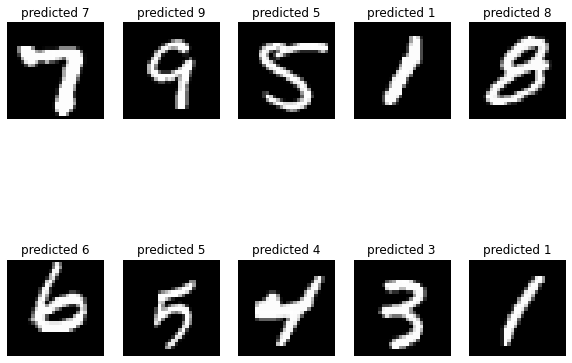

In [11]:
amnt_imgs = 10

actual_number = lbls[:amnt_imgs].numpy()

test_output, last_layer = cnn(imgs[:amnt_imgs])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f"Prediction number:\t\t {pred_y}")
print(f"Actual number:\t\t {actual_number}")


# The size of the figure is arbitrary
figure = plt.figure(figsize=(10, 8))

# Columns and rows obviously has to add up the amount if images
# otherwise it will be fugly
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    img = imgs[i - 1]
    label = pred_y[i - 1]
    figure.add_subplot(rows, cols, i)
    plt.title(f"predicted {label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()